# CAPM和因子模型

## 因子模型简介

在实务里，因子模型首先用于**业绩归因**：把一只股票、一个组合或一只基金在某一段时间的**超额收益**，分解成几部分——一部分来自**广泛而稳定地影响许多资产的共同影响因素**（如“大盘整体涨跌”“小盘风格相对大盘”“价值相对成长”等），另一部分是该资产或该管理人特有的成分（策略选择、择时或纯噪声）。  

这样做一般有3个目的：

* **解释**：回答“收益从哪里来”。例如，基金近期表现是否主要因为大盘走强，还是因为明显的价值（或小盘）倾向。  
* **评价**：区分“因子带来的正常回报”和“剥离因子后仍剩下的平均额外收益”（常记为 $\alpha$），从而更公平地评价管理能力。  
* **管理**：根据对因子“敏感度/斜率”的估计，控制或配置风格暴露，进行风险预算与再平衡（例如降低对单一风格的过度依赖）。

### 因子模型的基本思想

在一段时间尺度上，资产的期望收益可以写成“无风险利率 + 若干**共同影响因素**的线性组合 + 个体特有部分”。线性表达为：

$$
E[R_i] = R_f + \beta_{i1}\lambda_1 + \beta_{i2}\lambda_2 + \cdots + \beta_{ik}\lambda_k.
$$

这里，$\beta_{ij}$ 可以理解为**斜率/敏感度**：当第 $j$ 个因素的回报上升 $1$ 个单位时，资产 $i$ 的回报平均会随之变化多少；$\lambda_j$ 是该因素在样本期内对应的平均“回报补偿”。实际估计时，常用时间序列回归得到各 $\beta$，再用样本均值近似各因素的溢价。

### CAPM：以“大盘敏感度”解释超额收益

**思想**：如果把整个市场看作一只尽可能分散、按市值加权的“超大指数”，那么一只资产的超额收益，主要由它**随大盘一起涨跌的幅度**（斜率 $\beta$）决定。比如某只股票的涨跌总是跟随大盘，但是大盘涨的时候，这只股票涨得更快。

**回归形式**：

$$
R_{i,t}-R_{f,t} = \alpha_i + \beta_{i,M}(R_{M,t}-R_{f,t}) + \varepsilon_{i,t}.
$$

* $\beta_{i,M}$：对“大盘超额收益”的**斜率/敏感度**；可读作“大盘每变动 $1\%$，该资产平均变动 $\beta\%$”。  
* $\alpha_i$：在控制了大盘影响后仍然存在的**平均额外收益**；若 CAPM 完全成立，应接近 $0$。  
* 估计中通常使用月度总回报（含分红再投），并用 Newey–West 标准误修正自相关与异方差。

### FF3：引入“规模”与“价值”

**思想**：在市场因子之外，广泛数据中反复出现两种风格差异：小盘相对大盘、价值相对成长。把它们做成**可交易的多空组合**时间序列，纳入解释框架。  
**回归形式**：

$$
R_{i,t}-R_{f,t}
= \alpha_i
  + \beta_{i,M}(MKT_t - RF_t)
  + \beta_{i,SMB}SMB_t
  + \beta_{i,HML}HML_t
  + \varepsilon_{i,t}.
$$

* $MKT_t - RF_t=R_{M,t}-R_{f,t}$：市场超额收益。  
* $SMB_t$（Small Minus Big）：**小盘 − 大盘** 的多空组合当期回报；$\beta_{i,SMB}$ 是对“小盘相对大盘”这一差额的斜率。  
* $HML_t$（High Minus Low）：**高账面市值比 − 低账面市值比** 的多空组合回报；$\beta_{i,HML}$ 是对“价值相对成长”差额的斜率。  
* 直观解读：若 $\beta_{i,SMB}>0$，该资产更像“小盘风格”；若 $\beta_{i,HML}<0$，该资产更偏“成长风格”。

### FF5：再加入“盈利能力”与“投资”

**思想**：许多样本提示，**高盈利**公司往往有更高回报，而**低投资（更保守地扩张资产）**的公司在风险调整后回报更高。于是，在 FF3 的基础上加入两个因子。  
**回归形式**：

$$
R_{i,t}-R_{f,t}
= \alpha_i
  + \beta_{i,M}(MKT_t - RF_t)
  + \beta_{i,SMB}SMB_t
  + \beta_{i,HML}HML_t
  + \beta_{i,RMW}RMW_t
  + \beta_{i,CMA}CMA_t
  + \varepsilon_{i,t}.
$$

* $RMW_t$（Robust Minus Weak）：**高盈利 − 低盈利** 的多空组合回报；$\beta_{i,RMW}$ 是对“盈利维度差额”的斜率。  
* $CMA_t$（Conservative Minus Aggressive）：**低投资 − 高投资** 的多空组合回报；$\beta_{i,CMA}$ 是对“投资维度差额”的斜率。  
* **注意**：在 FF5 中，$SMB$ 的官方口径改为把三套分组（规模×价值、规模×盈利、规模×投资）得到的三个“小盘减大盘”序列取平均，以避免将规模与单一特征的耦合。

### 估计与解读

为便于对比与评分，建议采用如下统一做法：

1. **频率与口径**：使用月度总回报（含分红再投），所有序列按**月末**对齐；无风险利率与之同频。  
2. **回归**：以 OLS 估计各模型（CAPM、FF3、FF5），并使用固定滞后的 Newey–West 标准误（如滞后 $4$）,以处理时间序列同时出现自相关和异方差问题。  
3. **报告与图表**：
   * 报告 $\alpha$、各 $\beta$ 与 $R^2$；比较 CAPM 与 FF3/FF5 的 $R^2$ 是否上升、$\alpha$ 是否下降。  
   * 绘制 $\beta$ 的条形对比图或滚动窗口折线，以观察风格暴露是否随时间漂移。  
4. **解读**：
   * 若加入风格因子后 $R^2$ 明显提升、$\alpha$ 明显接近 $0$，说明该资产的收益主要来自若干**共同影响因素**，而不是独立于这些因素的“额外回报”。  
   * 残差并不自动等同于“真正的阿尔法”；它也可能来自未纳入的风险因素、样本噪声或口径差异。

### 变量与符号

* $R_{i,t}$：资产 $i$ 在 $t$ 期的收益（建议用月度总回报）。  
* $R_{f,t}$：无风险利率（同频）。  
* $R_{M,t}$：按市值加权的“宽基市场”收益。  
* $MKT_t - RF_t=R_{M,t}-R_{f,t}$：市场超额收益。  
* $SMB_t$：小盘 − 大盘 的多空组合回报（FF3：源自“规模×价值”的分组；FF5：三套分组平均）。  
* $HML_t$：高账面市值比 − 低账面市值比 的多空组合回报。  
* $RMW_t$：高盈利 − 低盈利 的多空组合回报。  
* $CMA_t$：低投资 − 高投资 的多空组合回报。  
* $\alpha_i$：在控制了各因素后，资产 $i$ 的平均额外收益。  
* $\beta_{i,\cdot}$：资产对相应因素的**斜率/敏感度**（“该因素变动 $1\%$，该资产平均变化多少”）。  
* $\varepsilon_{i,t}$：特异性误差项。

### 应用场景

* **基金与产品评估**：拆分一只基金的历史超额收益，判断其来源更接近“大盘/风格”的顺风，还是策略本身（$\alpha$）。  
* **风格监测与风险预算**：跟踪组合在“规模、价值、盈利、投资”等维度的斜率，控制不希望集中的风格暴露。  
* **产品设计与绩效沟通**：将目标敞口写入投资说明（例如“长期保持小盘与价值偏好”），并用因子回归按季披露是否达成。  
* **再平衡**：当某一风格暴露偏离目标带宽时，通过调仓或对冲 ETF/期货因子篮子进行修正。

## 数据来源

akshare这个包可以提供大量免费的证券市场数据，典型的就是股票的价格序列等。

需要安装（首次使用前安装即可），在任何一个Python单元格中执行一下代码，将会从清华大学的服务器下载并安装akshare，注意开头有一个感叹号。

`!pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple akshare`


包的说明见：https://akshare.akfamily.xyz/introduction.html



## CAPM



CAPM 把股票（或者组合或者基金）的收益看成是市场基准的收益的某个比例，称之为Beta。例如，如果大盘（或者某个参考指数）涨1%，这只股票涨10%，这就是一个高Beta股票。反之，大盘涨1%，这只股票涨0.1%，这就是一个小Beta股票。

我们以 300750 宁德时代 为例，构建CAPM分析。当然你也选择一个组合，或者一只基金。

数据的获取可以参考：

https://akshare.akfamily.xyz/data/stock/stock.html#id25

In [1]:
import akshare as ak
import pandas as pd
import numpy as np

In [2]:

stock_df = ak.stock_zh_a_daily(symbol="sz300750", start_date="20200101", end_date="20991231", adjust="qfq")
stock_df.head()

,date,open,high,low,close,volume,amount,outstanding_share,turnover
0,2020-01-02,55.96,56.81,55.17,56.12,20611589.0,2.213455e+09,1.202590e+09,0.017139
1,2020-01-03,56.12,57.51,55.31,57.18,18084178.0,1.956829e+09,1.202590e+09,0.015038
2,2020-01-06,58.09,59.76,56.27,56.94,26500200.0,2.958352e+09,1.202590e+09,0.022036
3,2020-01-07,56.90,57.23,56.06,56.63,13507544.0,1.461154e+09,1.202590e+09,0.011232
4,2020-01-08,56.90,58.20,55.90,57.20,19224068.0,2.098374e+09,1.202590e+09,0.015986


## 时间序列数据

我们把数据转为时间序列格式，可以利用时间的属性，比如获得特定时间段数据，日线转月线，算收益率等等，只要和日期有关都很容易操作。

做法：把日期列转为 datetime 格式（用 pd.to_datetime() 或者其他函数），然后再设置为 index 即可。

In [3]:
# 把列转为datetime格式（日期时间）
stock_df['date'] = pd.to_datetime(stock_df['date'])

# 设置为index
stock_df.set_index('date',inplace = True)
stock_df.head()

,open,high,low,close,volume,amount,outstanding_share,turnover
date,,,,,,,,
2020-01-02,55.96,56.81,55.17,56.12,20611589.0,2.213455e+09,1.202590e+09,0.017139
2020-01-03,56.12,57.51,55.31,57.18,18084178.0,1.956829e+09,1.202590e+09,0.015038
2020-01-06,58.09,59.76,56.27,56.94,26500200.0,2.958352e+09,1.202590e+09,0.022036
2020-01-07,56.90,57.23,56.06,56.63,13507544.0,1.461154e+09,1.202590e+09,0.011232
2020-01-08,56.90,58.20,55.90,57.20,19224068.0,2.098374e+09,1.202590e+09,0.015986


## 便利的日期操作

In [4]:
stock_df.loc['2025'].head() # 取1年数据

,open,high,low,close,volume,amount,outstanding_share,turnover
date,,,,,,,,
2025-01-02,258.85,258.90,249.86,251.59,23354576.0,6.090662e+09,3.902556e+09,0.005984
2025-01-03,251.59,255.69,250.06,250.47,18523758.0,4.812149e+09,3.902556e+09,0.004747
2025-01-06,250.83,252.77,245.97,249.61,17289077.0,4.433101e+09,3.902556e+09,0.004430
2025-01-07,236.25,245.00,234.38,242.52,40103599.0,9.934924e+09,3.902556e+09,0.010276
2025-01-08,239.15,241.41,236.56,238.52,27185752.0,6.681629e+09,3.902556e+09,0.006966


In [5]:
stock_df.loc['2022-06'].head() # 取某个月

,open,high,low,close,volume,amount,outstanding_share,turnover
date,,,,,,,,
2022-06-01,214.46,225.39,212.32,222.27,19178459.0,8.078892e+09,2.038657e+09,0.009407
2022-06-02,221.10,232.08,220.17,228.43,17447774.0,7.640887e+09,2.038657e+09,0.008558
2022-06-06,228.53,245.27,228.53,243.69,19037806.0,8.745175e+09,2.038657e+09,0.009338
2022-06-07,243.27,244.22,235.75,240.04,12759509.0,5.850494e+09,2.038657e+09,0.006259
2022-06-08,238.47,240.56,222.77,240.56,40541428.0,1.787005e+10,2.038657e+09,0.019886


In [6]:
stock_df.loc['2022':'2025-06'].head() # 还可以任意切片

,open,high,low,close,volume,amount,outstanding_share,turnover
date,,,,,,,,
2022-01-04,316.91,317.43,293.38,297.50,17456845.0,9.975828e+09,2.038657e+09,0.008563
2022-01-05,296.20,296.45,282.40,286.32,16657881.0,9.167983e+09,2.038657e+09,0.008171
2022-01-06,281.62,286.06,278.10,283.16,13882602.0,7.480051e+09,2.038657e+09,0.006810
2022-01-07,287.63,290.76,276.12,282.34,13169468.0,7.135967e+09,2.038657e+09,0.006460
2022-01-10,279.77,287.10,274.15,281.56,14862906.0,7.964180e+09,2.038657e+09,0.007291


In [7]:
# 取收盘价，注意也是时间序列
stock_close = stock_df['close']
stock_close.head()

date
2020-01-02    56.12
2020-01-03    57.18
2020-01-06    56.94
2020-01-07    56.63
2020-01-08    57.20
Name: close, dtype: float64

In [8]:
# 以下都是绘图例行公事，直接拷贝即可

import pandas as pd
import numpy as np 

# 导入matplotlib.pyplot绘图库，其中plt.plot()是最常用的绘图函数之一
import matplotlib.pyplot as plt 

import seaborn as sns

sns.set_theme() # 默认用seaborn的绘图样式

# 设置字体。如果不设置，中文可能会乱码。这里采用冬青黑、微软雅黑和文泉驿微米黑，可以兼容大多数操作系统。
plt.rcParams["font.sans-serif"]=["Hiragino Sans GB", "Microsoft YaHei", "WenQuanYi Micro Hei"] 

plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 绘图使用'svg'后端：svg是矢量格式，可以任意缩放均保持清晰，各种屏幕的显示良好。
%config InlineBackend.figure_formats = ['svg']

<Axes: xlabel='date'>

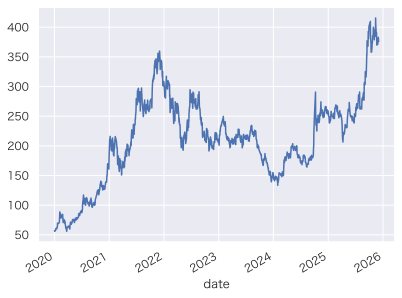

In [9]:
# 绘图：时间序列数据画出来默认是折线图
stock_close.plot()

In [10]:
# pct_change 可以计算时间序列的回报率序列
stock_close.pct_change().tail() # 计算回报率（今天/昨天-1）

date
2025-11-27   -0.004345
2025-11-28    0.005388
2025-12-01    0.026179
2025-12-02   -0.007546
2025-12-03   -0.010524
Name: close, dtype: float64

In [11]:
# 日线转为月线：按月分组（resample('ME')），然后去最后一个值：月线的收盘价
stock_close_m = stock_close.resample('ME').last()
stock_close_m


date
2020-01-31     68.15
2020-02-29     70.81
2020-03-31     62.84
2020-04-30     75.36
2020-05-31     75.96
               ...  
2025-08-31    306.18
2025-09-30    402.00
2025-10-31    388.77
2025-11-30    373.20
2025-12-31    376.08
Freq: ME, Name: close, Length: 72, dtype: float64

In [12]:
stock_ret_m = stock_close_m.pct_change() # 用月收盘价计算的，自然是月回报率的序列
stock_ret_m.tail() 

date
2025-08-31    0.161224
2025-09-30    0.312953
2025-10-31   -0.032910
2025-11-30   -0.040049
2025-12-31    0.007717
Freq: ME, Name: close, dtype: float64

## 比较基准

市场组合，这里我们采用中证全指。akshare中获得中证系列指数，可以看这里

https://akshare.akfamily.xyz/data/index/index.html#id64

In [13]:
import akshare as ak

csi_all_share_df  = ak.stock_zh_index_hist_csindex(symbol="000985", start_date="20200101", end_date="20990604")
csi_all_share_df.iloc[:5,:5]

,日期,指数代码,指数中文全称,指数中文简称,指数英文全称
0,2020-01-01,000985,中证全指指数,中证全指,CSI All Share Index
1,2020-01-02,000985,中证全指指数,中证全指,CSI All Share Index
2,2020-01-03,000985,中证全指指数,中证全指,CSI All Share Index
3,2020-01-06,000985,中证全指指数,中证全指,CSI All Share Index
4,2020-01-07,000985,中证全指指数,中证全指,CSI All Share Index


In [14]:
csi_all_share_df.columns # 检查有什么变量可以用

Index(['日期', '指数代码', '指数中文全称', '指数中文简称', '指数英文全称', '指数英文简称', '开盘', '最高', '最低',
       '收盘', '涨跌', '涨跌幅', '成交量', '成交金额', '样本数量', '滚动市盈率'],
      dtype='object')

In [15]:
# 同样，转为时间序列
csi_all_share_df['日期'] = pd.to_datetime(csi_all_share_df['日期'])
csi_all_share_df.set_index('日期',inplace = True)

# 取收盘价
csi_all_share_close = csi_all_share_df['收盘']
csi_all_share_close.tail()


日期
2025-11-27    5690.01
2025-11-28    5732.77
2025-12-01    5787.18
2025-12-02    5750.40
2025-12-03    5710.58
Name: 收盘, dtype: float64

看看价格走势对比

<Axes: >

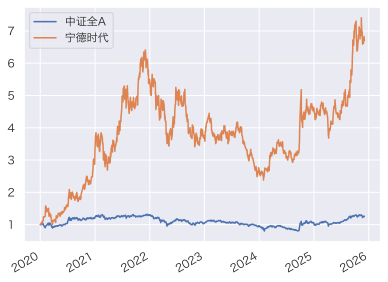

In [16]:
# 横向合并一下，记得pd.concat可以自动对齐index，这里就是对齐日期了
# dropna去掉缺失值

close_compare_df = pd.concat([csi_all_share_close, stock_close], axis = 1).dropna().loc['2020':]
close_compare_df = close_compare_df/close_compare_df.iloc[0]
close_compare_df.columns = ['中证全A','宁德时代']
close_compare_df.plot()

In [17]:
# 同样，计算月度收益率
result_df = close_compare_df.resample('ME').last().pct_change()
result_df.tail()

,中证全A,宁德时代
2025-08-31,0.107415,0.161224
2025-09-30,0.026469,0.312953
2025-10-31,-0.001499,-0.032910
2025-11-30,-0.022821,-0.040049
2025-12-31,-0.003871,0.007717


In [18]:
import akshare as ak

bond_zh_us_rate_df = ak.bond_zh_us_rate(start_date="20200101")
bond_zh_us_rate_df.iloc[:5,:5]

  0%|          | 0/19 [00:00<?, ?it/s]

,日期,中国国债收益率2年,中国国债收益率5年,中国国债收益率10年,中国国债收益率30年
0,2020-01-02,2.5316,2.9156,3.1485,3.7324
1,2020-01-03,2.5366,2.9353,3.1428,3.7265
2,2020-01-06,2.5048,2.9059,3.1352,3.7160
3,2020-01-07,2.4926,2.9179,3.1379,3.7213
4,2020-01-08,2.5038,2.9020,3.1337,3.7122


In [19]:
bond_zh_us_rate_df['日期'] = pd.to_datetime(bond_zh_us_rate_df['日期'])
bond_zh_us_rate_df.set_index('日期',inplace = True)
bond_zh_us_rate_df['中国国债收益率10年']


日期
2020-01-02    3.1485
2020-01-03    3.1428
2020-01-06    3.1352
2020-01-07    3.1379
2020-01-08    3.1337
               ...  
2025-11-27    1.8537
2025-11-28    1.8412
2025-12-01    1.8366
2025-12-02    1.8442
2025-12-03    1.8519
Name: 中国国债收益率10年, Length: 1582, dtype: float64

注意到，这个序列是“每天的年化收益率 * 100”，我们要获得月度收益率，如何做呢？

1. 计算日收益率序列
    - （1 + 上述序列 / 100）： 1.8442 -> 1.018442，按这个利率存1年可以得到多少钱
    - （1 + 上述序列 / 100）** (1/365) : 开356次方 -> 每天的收益率。
2. 对上述结果，使用连乘：第一天存入1元的净值走势。
3. 对净值走势计算月末值，然后计算月度收益率。


<Axes: xlabel='日期'>

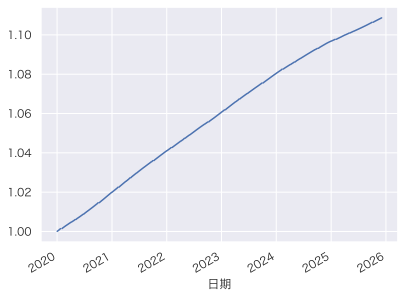

In [20]:

rate = (1 + bond_zh_us_rate_df['中国国债收益率10年']/100) ** (1/365)
rate.cumprod().plot()


In [21]:
# resample到月，然后计算月度收益率
rate_m = rate.cumprod().resample("ME").last().pct_change()
rate_m.tail()

日期
2025-08-31    0.000999
2025-09-30    0.001161
2025-10-31    0.000896
2025-11-30    0.000987
2025-12-31    0.000150
Freq: ME, Name: 中国国债收益率10年, dtype: float64

把3个月度收益率并在一起，CAPM 要用的数据就集齐了。

In [22]:
result_df = pd.concat([result_df,rate_m],axis=1).dropna()
result_df.head()

,中证全A,宁德时代,中国国债收益率10年
2020-02-29,0.000898,0.039032,0.001531
2020-03-31,-0.064712,-0.112555,0.001579
2020-04-30,0.053326,0.199236,0.001514
2020-05-31,0.002880,0.007962,0.001378
2020-06-30,0.079660,0.199842,0.001605


In [23]:
import statsmodels.api as sm


CAPM 把超额收益解释为对大盘的“弹性”：大盘如果涨，这只股票是否比大盘涨得更快？

In [24]:
# 计算2个超额收益
stock_ret = result_df['宁德时代'] - result_df['中国国债收益率10年']
stock_ret.name = 'stock return'

index_ret = result_df['中证全A'] - result_df['中国国债收益率10年']
index_ret.name = 'market return'

# 常规回归
y = stock_ret
X = index_ret
X = sm.add_constant(X)
X.head() # 注意，多了一列const

,const,market return
2020-02-29,1.0,-0.000633
2020-03-31,1.0,-0.066291
2020-04-30,1.0,0.051812
2020-05-31,1.0,0.001502
2020-06-30,1.0,0.078055


In [25]:
# 创建OLS回归模型的实例并拟合数据
model = sm.OLS(y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4}) # 使用滞后4期的 Newey–West 标准误
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           stock return   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     85.06
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.17e-13
Time:                        15:52:08   Log-Likelihood:                 63.802
No. Observations:                  71   AIC:                            -123.6
Df Residuals:                      69   BIC:                            -119.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0252      0.010      2.517

In [26]:
from IPython.display import display, Math

params = results.params

alpha = params.get('const', 0.0)
beta  = params[[name for name in params.index if name != 'const'][0]]

print('回归线是：')
display(Math(r"$R_{it}^e = " + f"{alpha:.3f}" + " + " + f"{beta:.3f}" + "R_{Mt}^e$"))

回归线是：


<IPython.core.display.Math object>

## 简单解读

1. 常数项（Alpha）：控制了市场因子后（控制了大盘涨跌的“带动”），这只股票依然每个月能带来3%的超额收益，并且是显著的。

2. 市场因子（Beta）：市场组合每增加1单位超额收益，这只股票会增加1.45单位的超额收益。从CAPM来看，是一个高beta的股票：涨得时候涨得比大盘快，或者是“进取型”“进攻型”股票。

## Fama-French 3因子模型

CAPM 大致上是在表达：如果你知道了一只股票的 beta，就能知道它相对大盘的走势。等于说一只股票的风险主要来自大盘，剩下的都是不可解释的随机因素。

实际上，FF他们发现，现实中的股票收益率，和公司规模、账面市值比高度相关。显然，只和大盘比弹性（beta）不能完全解释收益。还有2个因素也很重要：

1. 规模效应：长期而言，小盘股有超额收益
2. 价值效应：长期而言，价值股（账面市值比高，账面值“便宜”的价值股）有超额收益

显然我们应该把规模因素和价值因素都考虑进去。

这就是 Fama-French 3因子模型的基本思想。










## 构造规模和价值因子

### 正规做法

1. **先按 Size 和 B/M 对股票分组**

   * 每年按市值分 Small / Big，
   * 按 (B/M) 分 Low / Medium / High，
   * 得到 6 个组合：SL, SM, SH, BL, BM, BH。

2. **从这些组合中合成多空组合**，把“特征”变成可以交易的“因子收益”：

   * 规模因子 SMB（Small Minus Big）：

$$
SMB_t
= \frac{R_{SL,t} + R_{SM,t} + R_{SH,t}}{3} - \frac{R_{BL,t} + R_{BM,t} + R_{BH,t}}{3}
$$
       表示“同样的价值特征下，小盘股组合 − 大盘股组合”的平均差。

   * 价值因子 HML（High Minus Low）：

$$
HML_t
= \frac{R_{SH,t} + R_{BH,t}}{2} - \frac{R_{SL,t} + R_{BL,t}}{2}
$$
       表示“在控制 Size 之后，高 (B/M) − 低 (B/M) 的差异”。



### 简单做法

因为数据获得比较麻烦，我们这里采用一个非常简单的替代做法，用几个指数的收益来来替代:

**注意：这种替代是粗糙和不精确的，只是作为概念的演示**

1. 大盘价值：300价值 000919
2. 小盘价值：中证1000价值 932392
3. 大盘成长：沪深300成长 000918
4. 小盘成长：中证1000成长 932393

SMB（规模因子）的算法：

1. 在 价值风格内部：小盘价值 − 大盘价值
2. 在 成长风格内部：小盘成长 − 大盘成长

然后对这两个差取平均

SMB = ((小盘价值 - 大盘价值) + (小盘成长 - 大盘成长))/2

HML（价值因子）的算法：类似

HML = ((大盘价值 - 大盘成长) + (小盘价值 - 小盘成长))/2

In [27]:
csi_300_value_df  = ak.stock_zh_index_hist_csindex(symbol="000919", start_date="20200101", end_date="20990604")
csi_300_value_df.iloc[:5,:5]

,日期,指数代码,指数中文全称,指数中文简称,指数英文全称
0,2020-01-01,000919,沪深300价值指数,300价值,CSI 300 Value Index
1,2020-01-02,000919,沪深300价值指数,300价值,CSI 300 Value Index
2,2020-01-03,000919,沪深300价值指数,300价值,CSI 300 Value Index
3,2020-01-06,000919,沪深300价值指数,300价值,CSI 300 Value Index
4,2020-01-07,000919,沪深300价值指数,300价值,CSI 300 Value Index


In [28]:
csi_300_growth_df  = ak.stock_zh_index_hist_csindex(symbol="000918", start_date="20200101", end_date="20990604")
csi_300_growth_df.iloc[:5,:5]

,日期,指数代码,指数中文全称,指数中文简称,指数英文全称
0,2020-01-01,000918,沪深 300 成长指数,300成长,CSI 300 Growth Index
1,2020-01-02,000918,沪深 300 成长指数,300成长,CSI 300 Growth Index
2,2020-01-03,000918,沪深 300 成长指数,300成长,CSI 300 Growth Index
3,2020-01-06,000918,沪深 300 成长指数,300成长,CSI 300 Growth Index
4,2020-01-07,000918,沪深 300 成长指数,300成长,CSI 300 Growth Index


In [29]:
csi_1000_value_df  = ak.stock_zh_index_hist_csindex(symbol="932392", start_date="20200101", end_date="20990604")
csi_1000_value_df.iloc[:5,:5]

,日期,指数代码,指数中文全称,指数中文简称,指数英文全称
0,2020-01-01,932392,中证1000价值指数,1000价值,CSI 1000 Value Index
1,2020-01-02,932392,中证1000价值指数,1000价值,CSI 1000 Value Index
2,2020-01-03,932392,中证1000价值指数,1000价值,CSI 1000 Value Index
3,2020-01-06,932392,中证1000价值指数,1000价值,CSI 1000 Value Index
4,2020-01-07,932392,中证1000价值指数,1000价值,CSI 1000 Value Index


In [30]:
csi_1000_growth_df  = ak.stock_zh_index_hist_csindex(symbol="932393", start_date="20200101", end_date="20990604")
csi_1000_growth_df.iloc[:5,:5]

,日期,指数代码,指数中文全称,指数中文简称,指数英文全称
0,2020-01-01,932393,中证1000成长指数,1000成长,CSI 1000 Growth Index
1,2020-01-02,932393,中证1000成长指数,1000成长,CSI 1000 Growth Index
2,2020-01-03,932393,中证1000成长指数,1000成长,CSI 1000 Growth Index
3,2020-01-06,932393,中证1000成长指数,1000成长,CSI 1000 Growth Index
4,2020-01-07,932393,中证1000成长指数,1000成长,CSI 1000 Growth Index


In [31]:
def convert(x):
    x['日期'] = pd.to_datetime(x['日期'])
    
    result = x.set_index('日期')['收盘']
    
    result.name = x['指数中文简称'].values[0]
    
    return result

value_growth_df = pd.concat([convert(csi_1000_growth_df),
          convert(csi_1000_value_df),
          convert(csi_300_growth_df),
          convert(csi_300_value_df)],
          axis=1
          )
value_growth_df.head()

,1000成长,1000价值,300成长,300价值
日期,,,,
2020-01-01,1910.75,1989.81,5121.80,5168.89
2020-01-02,1910.75,1989.81,5121.80,5168.89
2020-01-03,1920.94,1991.78,5076.46,5168.56
2020-01-06,1943.95,2002.98,5040.26,5122.84
2020-01-07,1976.77,2029.90,5088.61,5152.38


In [32]:
value_growth_m_ret_df = value_growth_df.resample("ME").last().pct_change()
value_growth_m_ret_df.tail()

,1000成长,1000价值,300成长,300价值
日期,,,,
2025-08-31,0.160303,0.043344,0.143326,0.013754
2025-09-30,0.065118,0.006242,0.094960,-0.046035
2025-10-31,-0.015397,0.027259,-0.020511,0.034982
2025-11-30,-0.035794,-0.023337,-0.028421,0.005871
2025-12-31,-0.012045,0.010604,0.002679,0.003614


In [33]:
ff3_df = pd.concat([result_df,value_growth_m_ret_df],axis=1)
ff3_df.head()

,中证全A,宁德时代,中国国债收益率10年,1000成长,1000价值,300成长,300价值
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,0.000898,0.039032,0.001531,0.062793,-0.024304,-0.018842,-0.041301
2020-03-31,-0.064712,-0.112555,0.001579,-0.087522,-0.031758,-0.057734,-0.066236
2020-04-30,0.053326,0.199236,0.001514,0.046666,0.037566,0.093922,0.037990
2020-05-31,0.002880,0.007962,0.001378,0.019101,-0.007981,0.019426,-0.029721



SMB = ((小盘价值 - 大盘价值) + (小盘成长 - 大盘成长))/2

HML = ((大盘价值 - 大盘成长) + (小盘价值 - 小盘成长))/2

In [34]:
ff3_df['SMB'] = ((ff3_df['1000价值'] - ff3_df['300价值']) + (ff3_df['1000成长'] - ff3_df['300成长'])) / 2
ff3_df['HML'] = ((ff3_df['300价值'] - ff3_df['300成长']) + (ff3_df['1000价值'] - ff3_df['1000成长'])) / 2
ff3_df.head()

,中证全A,宁德时代,中国国债收益率10年,1000成长,1000价值,300成长,300价值,SMB,HML
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,0.000898,0.039032,0.001531,0.062793,-0.024304,-0.018842,-0.041301,0.049316,-0.054778
2020-03-31,-0.064712,-0.112555,0.001579,-0.087522,-0.031758,-0.057734,-0.066236,0.002345,0.023631
2020-04-30,0.053326,0.199236,0.001514,0.046666,0.037566,0.093922,0.037990,-0.023840,-0.032516
2020-05-31,0.002880,0.007962,0.001378,0.019101,-0.007981,0.019426,-0.029721,0.010707,-0.038114


In [35]:
ff3_df['stock return'] = ff3_df['宁德时代'] - ff3_df['中国国债收益率10年']
ff3_df['market return'] = ff3_df['中证全A'] - ff3_df['中国国债收益率10年']

ff3_df = ff3_df.dropna()
ff3_df.iloc[:5,:5]

,中证全A,宁德时代,中国国债收益率10年,1000成长,1000价值
2020-02-29,0.000898,0.039032,0.001531,0.062793,-0.024304
2020-03-31,-0.064712,-0.112555,0.001579,-0.087522,-0.031758
2020-04-30,0.053326,0.199236,0.001514,0.046666,0.037566
2020-05-31,0.002880,0.007962,0.001378,0.019101,-0.007981
2020-06-30,0.079660,0.199842,0.001605,0.123716,0.030885


In [36]:

# 常规回归
y = ff3_df['stock return']
X = ff3_df[['market return','SMB','HML']]
X = sm.add_constant(X)
X.head() # 注意，多了一列const

,const,market return,SMB,HML
2020-02-29,1.0,-0.000633,0.049316,-0.054778
2020-03-31,1.0,-0.066291,0.002345,0.023631
2020-04-30,1.0,0.051812,-0.023840,-0.032516
2020-05-31,1.0,0.001502,0.010707,-0.038114
2020-06-30,1.0,0.078055,0.019540,-0.094160


In [37]:
# 创建OLS回归模型的实例并拟合数据
model = sm.OLS(y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           stock return   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     24.86
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           6.34e-11
Time:                        15:52:09   Log-Likelihood:                 74.942
No. Observations:                  71   AIC:                            -141.9
Df Residuals:                      67   BIC:                            -132.8
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0298      0.010      3.034

## 简单解读

1. const：常数项（Alpha），这只股票在考虑其他因素后，依然有显著的超额收益，可能来自自行业（新能源/动力电池）、技术领先、政策预期等未被三因子捕捉的东西。
2. index_ret：市场因子（Beta），在考虑其他因素后，这只股票的Beta略小于1，这是一只波动率小于市场平均水平的股票。
3. SMB：市值因子：小于0且显著，在考虑其他因素后，这只股票偏向大盘股风格。
4. HML：价值因子：小于0且显著，在考虑其他因素后，这只股票偏向成长股风格。

这是一只“大盘成长股”，并且有很强的Alpha（3因子模型无法解释的超额收益，每个月多涨3%），对市场相对不敏感（Beta < 1）。







## 作业

### 构造FF 3因子模型
对一只你感兴趣的股票或者基金，用FF 3因子模型来分析其收益来源。

### 构造FF 5因子模型

注意：难度超纲。如果你想参赛，或者考较好的金融学的研究生，可以考虑做一下。

FF 5因子模型，比如3因子模型又多了2个因子：

1. RMW（Robust Minus Weak）——盈利因子

- 理念：高盈利公司平均收益更高。

- 原始构造：按 Size × 盈利能力分组，构造“高盈利组合 − 低盈利组合”。

2. CMA（Conservative Minus Aggressive）——投资因子

- 理念：投资保守（资产增长低）的公司平均收益更高；激进扩张的公司未来收益反而偏低。

- 原始构造：按 Size × 投资率/资产增长分组，构造“保守投资组合 − 激进投资组合”。

具体而言，基本都沿用 FF 思路：

对盈利（R/W）和投资（C/A）都做 Size×特征分组，然后因子是“高 − 低”组合的平均。比如：


$$
\text{RMW}_t = \frac{SR_t + BR_t}{2} - \frac{SW_t + BW_t}{2}
$$

$$
\text{CMA}_t = \frac{SC_t + BC_t}{2} - \frac{SA_t + BA_t}{2}
$$

其中：

* (SR,SW)：Small + Robust / Weak 盈利组合
* (BR,BW)：Big + Robust / Weak 盈利组合
* (SC,SA)：Small + Conservative / Aggressive 投资组合
* (BC,BA)：Big + Conservative / Aggressive 投资组合


